In [2]:
from functools import partial
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

import jax
from jax import numpy as jnp
from jax import random

Mixture of gaussians

In [3]:
def gaussian(x, norm, mu, sigma):
    """Single Gaussian distribution"""
    return norm * jnp.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * jnp.sqrt(2 * np.pi))


def gmm(x, norm, mu, sigma):
    """Gaussian Mixture Model"""
    values = jnp.sum(gaussian(x, norm, mu, sigma), axis=0) / mu.shape[0]

    # later we compute the gradient, which requires a returning a scalar value
    if values.shape == (1,):
        return values[0]
    
    return values


Text(0, 0.5, 'p(x)')

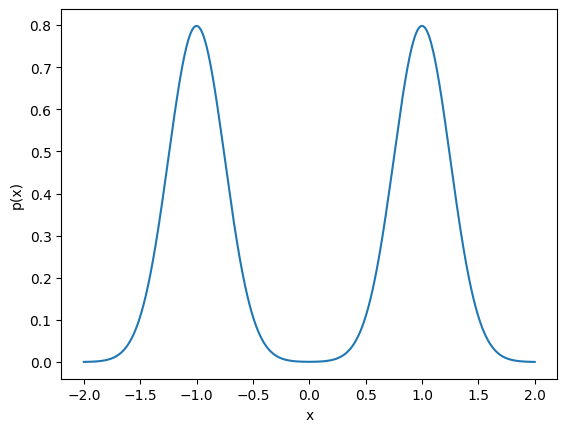

In [4]:

norm, mu, sigma = jnp.array([1, 1])[:, None], jnp.array([-1, 1])[:, None], jnp.array([0.25, 0.25])[:, None]

x_plot = jnp.linspace(-2, 2, 1000)
y = gmm(x_plot, norm, mu, sigma)
ax = plt.subplot()
ax.plot(x_plot, y)
ax.set_xlabel('x')
ax.set_ylabel('p(x)')

Using jax we can easily sample from this:

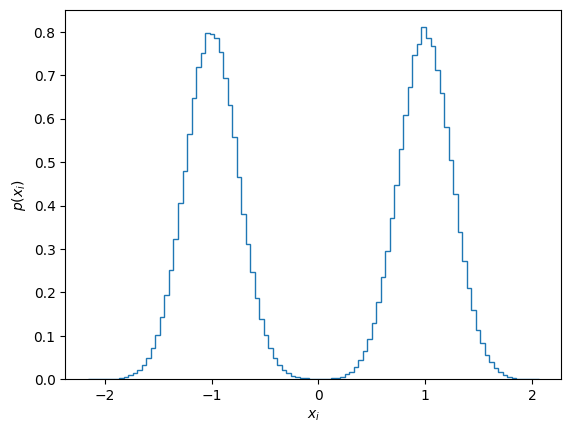

In [5]:
n_samples_ = 500_000
key = random.key(33)
x_init = sigma*random.normal(key, (2, n_samples_//2,)) + mu # assumes equal 'norm', use bernoulli to sample from the two gaussians if not
ax = plt.subplot()
ax.hist(x_init.flatten(), bins=100, density=True, histtype='step', label="Initial samples");
ax.set_xlabel('$x_i$')
ax.set_ylabel('$p(x_i)$');

## Diffusion process

Forward diffusion, in general is given by a SDE if the form:

$$
dx = f(x, t) dt + g(t) dw
$$

Here we will use a simple discrete-time version of this process, where at each step we apply the following transformation:

$$
x_{t+1} = \sqrt{1 - \beta_t} \cdot x_t + \beta_t \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

Drifts the mean toward zero and adds noise, eventually converging to a standard normal distribution.   The actual timetable of $\beta_t$ is a hyperparameter, for simplicity we will use a linear schedule from 0 to 1.

In [6]:
n_iter = 100
beta_t = jnp.linspace(0, 1, n_iter)
x = x_init.flatten()

sample_trace_diffusion_beta = []

for idx, beta in enumerate(beta_t):
    key, sub_key = random.split(key)
    x = jnp.sqrt(1. - beta) * x + beta * random.normal(key=sub_key, shape=x.shape)
    sample_trace_diffusion_beta.append(x)

sample_trace_diffusion_beta = jnp.stack(sample_trace_diffusion_beta, axis=0)

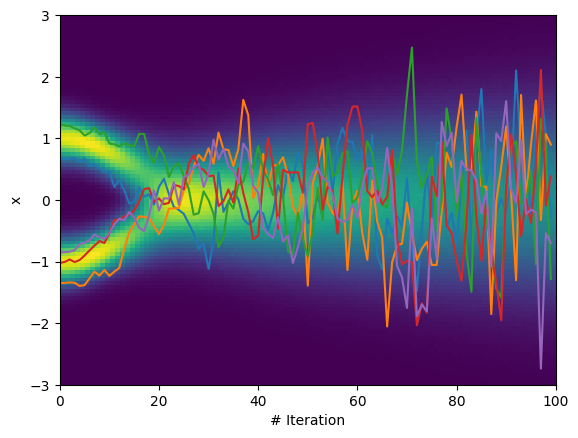

In [7]:
default_hist = partial(jnp.histogram, bins=100, range=(-3, 3), density=True)

batched_histogram = jax.vmap(default_hist)

def plot_trace(trace, n_traces=5, ax=None, x_min=-3, x_max=3):
    """Plot distribution at multiple points in time as trace"""
    hist_values, _ = batched_histogram(trace)    

    n_iter, n_samples = trace.shape

    ax = plt.subplot() or ax
    ax.imshow(hist_values.T[:, :], extent=[0, n_iter, x_min, x_max], aspect="auto", origin="lower")

    # plot some example traces
    key = random.PRNGKey(9823)
    for idx in random.randint(key, (n_traces,), 0, n_samples):
        ax.plot(trace[:, idx])

    ax.set_ylim(x_min, x_max)
    ax.set_xlabel("# Iteration")
    ax.set_ylabel("x")
    return ax

plot_trace(sample_trace_diffusion_beta);


###  Langevin dynamics

The SDE
$$
dx = -D \nabla_x U(x) \, dt + \sqrt{2D} \, dW
$$

has a stationary distribution $p(x) \propto e^{-U(x)}$.   

So one way that we can draw samples from a distribution is to run Langevin dynamics with $U(x) = -\log p(x)$:

$$
dx = D \nabla_x \log p(x) \, dt + \sqrt{2D} \, dW
$$

The vector function $\nabla_x \log p(x)$ is called the score function, and it points in the direction of increasing probability.  So this process drifts toward higher probability regions, while also adding noise to ensure that we explore the space.  Note that the score here is **fixed** — it's the score of the target distribution $p(x)$, not of some time-varying marginal.  We simply run the dynamics long enough to reach equilibrium.

Note that we need to know the score function to run this process, which is in general not known.  However, in some cases it is: for example we often know a posterior up to a normalizing constant and can compute the score function (which doesn't depend on the normalizing constant). This leads to [Bayesian Learning via Stochastic Gradient Langevin Dynamics](https://www.stats.ox.ac.uk/~teh/research/compstats/WelTeh2011a.pdf) which can compete with HMC in certain cases, for example with large data sets since this is compatible with 'batched' learning.  

The discrete-time Langevin update is:
$$
x_{t+1} = x_t + \frac{\alpha}{2} \nabla_x \log p(x) + \sqrt{\alpha} \cdot z, \quad z \sim \mathcal{N}(0, I)
$$

$\alpha$ is the step size, which can be thought of as a learning rate, which we can decrease toward zero to ensure convergence. 


In this case we **do** know the score function as we can just compute the derivative using jax. 

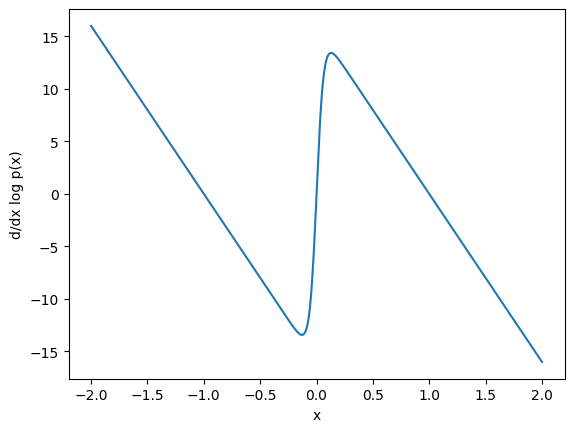

In [8]:
def log_gmm(x, norm, mu, sigma):
    """Log of the GMM"""
    return jnp.log(gmm(x, norm, mu, sigma))

gmm_log_part = partial(log_gmm, norm=norm, mu=mu, sigma=sigma) # the partial just simplifies not parsing the parameters later...
score_fun = jax.vmap(jax.grad(gmm_log_part))

ax = plt.subplot()
x_plot = jnp.linspace(-2, 2, 1000)
ax.plot(x_plot, score_fun(x_plot))
ax.set_xlabel('x')
ax.set_ylabel('d/dx log p(x)');

So we can kind of see the intuition here.. The score function is pushing the samples towards the modes of the distribution, while the noise is adding some randomness to prevent getting stuck in local minima.  As we iterate this process, we should see the samples converging to the true distribution.

PS: Note the functional style that is used here.  scan works a lot like foldl in Haskell.

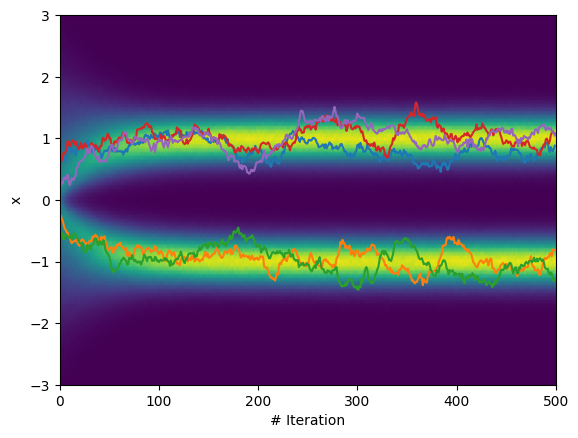

In [10]:
# JAX can natively handle "structs of arrays" or "PyTrees"
SampleArgs = namedtuple("Args", ["key", "idx", "x", "alpha_0", "p_0"])

def sample(score, args, _):
    # compute the "learning rate" depending on the iteration
    alpha = args.alpha_0 * (args.p_0 ** args.idx) ** 2

    # sample stochastic update
    key, subkey = random.split(args.key)
    dx = random.normal(subkey, args.x.shape)

    # combine the gradient and the stochastic update
    x = args.x + 0.5 * alpha * score(args.x) + jnp.sqrt(alpha) * dx
    return SampleArgs(key, args.idx + 1, x, args.alpha_0, args.p_0), x


n_samples = 100_000
n_iter = 500

key = random.PRNGKey(42)
key, subkey = random.split(key)

init = SampleArgs(
    key=key,
    idx=0,
    x=random.normal(subkey, (n_samples,)),
    alpha_0=0.002,
    p_0=1.0
)

result, sample_trace = jax.lax.scan(partial(sample, score_fun), init, length=n_iter)
plot_trace(sample_trace);

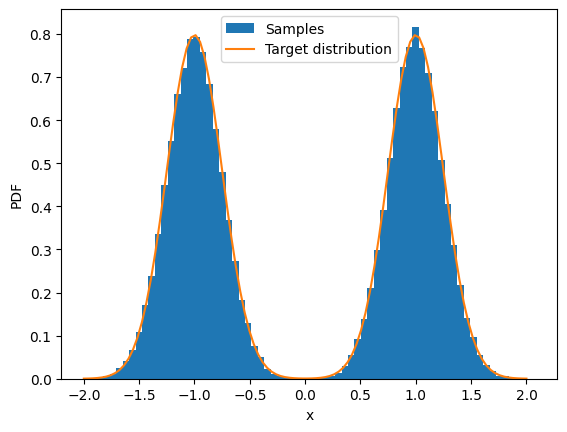

In [11]:
ax = plt.subplot()
ax.hist(sample_trace[-1], density=True, bins=70, label="Samples")

x_plot = jnp.linspace(-2, 2, 100)
y = gmm(x_plot, norm, mu, sigma)
ax.plot(x_plot, y, label="Target distribution")
ax.set_xlim()
ax.set_xlabel("x")
ax.set_ylabel("PDF")
ax.legend();

So this works, if we know the score we can use Langevin dynamics to sample from the score function. But for SBI we generally dont know the score function, all we have is draws from the distribution.  So we need to learn the score function from data, which is what score matching is for.  We will get to that in the next section.

## Score matching

In general we dont have access to the score function, we only have access to the data distribution.  But we can still estimate the score function using a technique called score matching, which is a way to train a model to approximate the score function.  The idea is to minimize the following objective:
$$
J(\theta) = \mathbb{E}_{p(x)} \left[  \| s_\theta(x) - \nabla_x \log p_\text{data}(x) \|^2 \right]
$$

Although we dont have access to the score function, we can still compute the gradient of the log density using the data distribution.  However by integrating by parts (see references) we can show that this objective is equivalent to:
$$
J(\theta) = \mathbb{E}_{p(x)} \left[  \|s_\theta(x) \|^2 + 2 tr(\nabla_x  s_\theta(x) )\right] + \text{const}
$$  



Here the blog post this is based on switches to a different problem, the 'Jelly Roll' dataset, which is a 2D dataset that looks like a jelly roll.  The idea is to train a neural network to approximate the score function for this dataset, and then use it to sample from the reverse process.

BBut i would rather stick to the original case and see if we can get it to work!

In [11]:
def init_mlp(key, layer_sizes):
    """Initialize MLP parameters with He initialization."""
    params = []
    for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
        key, subkey = random.split(key)
        w = random.normal(subkey, (in_size, out_size)) * jnp.sqrt(2.0 / in_size)
        b = jnp.zeros(out_size)
        params.append((w, b))
    return params

def mlp(params, x):
    """MLP forward pass: scalar -> scalar."""
    h = jnp.atleast_1d(x)
    for w, b in params[:-1]:
        h = jnp.tanh(h @ w + b)
    w, b = params[-1]
    return (h @ w + b).squeeze()

In [12]:
def score_matching_loss(params, samples):
    """Implicit score matching loss (Hyvärinen 2005).
    
    In 1D the general objective simplifies to:
      J = E[ s(x)^2 / 2 + ds/dx ]
    where s(x) is the model's score estimate and ds/dx is its derivative w.r.t. x.
    """
    model = lambda x: mlp(params, x)
    scores = jax.vmap(model)(samples)
    norm_loss = scores ** 2 / 2.0
    score_deriv = jax.vmap(jax.grad(model))(samples)
    return (norm_loss + score_deriv).mean()

In [14]:
import optax

key = random.PRNGKey(0)
params = init_mlp(key, [1, 128, 128, 1])

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(params)

train_data = x_init.flatten()
batch_size = 512

@jax.jit
def train_step(params, opt_state, batch):
    loss, grads = jax.value_and_grad(score_matching_loss)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

n_epochs = 50
losses = []

for epoch in range(n_epochs):
    key, subkey = random.split(key)
    perm = random.permutation(subkey, train_data.shape[0])
    shuffled = train_data[perm]

    epoch_losses = []
    for i in range(0, len(shuffled) - batch_size, batch_size):
        batch = shuffled[i:i+batch_size]
        params, opt_state, loss = train_step(params, opt_state, batch)
        epoch_losses.append(loss)

    avg_loss = jnp.mean(jnp.array(epoch_losses))
    losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}, loss: {avg_loss:.4f}")

print(f"Epoch {n_epochs-1:3d}, loss: {losses[-1]:.4f}")

Epoch   0, loss: -7.2484
Epoch  10, loss: -7.9562
Epoch  20, loss: -7.9595
Epoch  30, loss: -7.9634
Epoch  40, loss: -7.9618
Epoch  49, loss: -7.9602


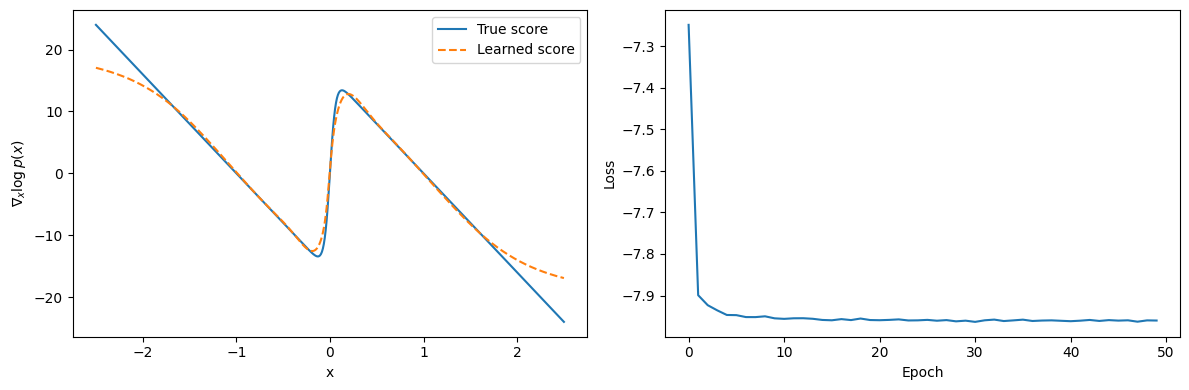

In [15]:
learned_score = jax.vmap(lambda x: mlp(params, x))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x_plot = jnp.linspace(-2.5, 2.5, 500)
axes[0].plot(x_plot, score_fun(x_plot), label="True score")
axes[0].plot(x_plot, learned_score(x_plot), '--', label="Learned score")
axes[0].set_xlabel('x')
axes[0].set_ylabel(r'$\nabla_x \log p(x)$')
axes[0].legend()

axes[1].plot(losses)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
plt.tight_layout();

Now plug the learned score into the Langevin sampler we already have — starting from pure noise, we should recover the GMM using only the learned score (no access to the true density).

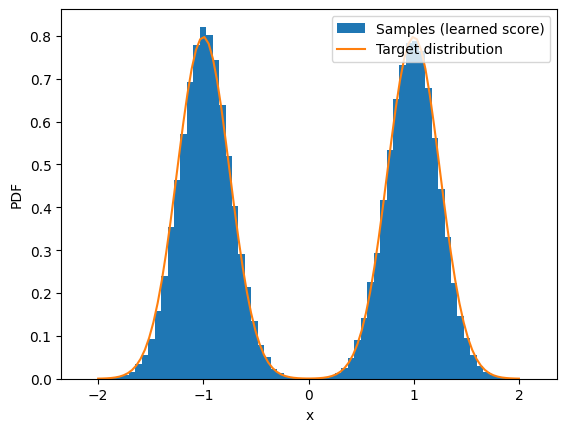

In [16]:
key = random.PRNGKey(99)
key, subkey = random.split(key)

init_learned = SampleArgs(
    key=key, idx=0,
    x=random.normal(subkey, (n_samples,)),
    alpha_0=0.002, p_0=1.0
)

_, sample_trace_learned = jax.lax.scan(
    partial(sample, learned_score), init_learned, length=n_iter
)

ax = plt.subplot()
ax.hist(sample_trace_learned[-1], density=True, bins=70, label="Samples (learned score)")
x_plot = jnp.linspace(-2, 2, 100)
ax.plot(x_plot, gmm(x_plot, norm, mu, sigma), label="Target distribution")
ax.set_xlabel("x")
ax.set_ylabel("PDF")
ax.legend();

## Denoising Diffusion Probabilistic Models (DDPM)

[ ] TODO: Verify and clarify this

### Reverse diffusion:

The SDE for the reverse process is given by (Anderson 1982):
$$
dx = \left[f(x, t) - g(t)^2 \nabla_x \log p_t(x)\right] dt + g(t) \, d\bar{W}
$$  

where $\bar{W}$ is a reverse-time Wiener process. Where does this come from?

### Deriving the reverse SDE from the Fokker-Planck equation

Recall that the forward SDE $dx = f\,dt + g\,dW$ generates marginal distributions $p_t(x)$ that satisfy the Fokker-Planck equation:
$$
\partial_t p_t = -\nabla \cdot (f \, p_t) + \frac{g^2}{2}\nabla^2 p_t
$$

The key trick is to rewrite the diffusion term using the score. Since $\nabla p_t = p_t \nabla \log p_t$:
$$
\frac{g^2}{2}\nabla^2 p_t = \nabla \cdot \left(\frac{g^2}{2} \nabla p_t\right) = \nabla \cdot \left(\frac{g^2}{2} \, p_t \, \nabla \log p_t\right)
$$

Substituting back into the FPE:
$$
\partial_t p_t = -\nabla \cdot \left[\left(f - \frac{g^2}{2}\nabla \log p_t\right) p_t\right] + \frac{g^2}{2}\nabla^2 p_t
$$

This is itself a valid Fokker-Planck equation -- but for a *different* SDE, one with drift $\tilde{f} = f - \frac{g^2}{2}\nabla \log p_t$ and the same diffusion coefficient $g$.

Now reverse time: $\partial_t p \to -\partial_t p$ flips the sign of the probability current (the divergence term) but not the diffusion term:
$$
-\partial_t p_t = -\nabla \cdot \left[-\left(f - \frac{g^2}{2}\nabla \log p_t\right) p_t\right] + \frac{g^2}{2}\nabla^2 p_t
$$
$$
\partial_\tau p = -\nabla \cdot \left[\left(-f + \frac{g^2}{2}\nabla \log p_t\right) p_t\right] + \frac{g^2}{2}\nabla^2 p_t
$$

Reading off the drift of the reversed FPE: $-f + \frac{g^2}{2}\nabla \log p_t$. But we also pick up another $\frac{g^2}{2}\nabla \log p_t$ from the diffusion term (same argument as above, in reverse), giving the total reverse drift:

$$
f_{\text{rev}} = -f + g^2 \nabla \log p_t
$$

or equivalently, writing $dt$ as running backwards: $dx = [f - g^2 \nabla_x \log p_t(x)]\,dt + g\,d\bar{W}$.
